#Assignment 3.2: LSTM ASSIGNMENT

This assignment is aimed at implementing LSTMs that we had learnt in class. In this task, we'll implement a model that takes text data as input and returns the emotion behind the text.

## TEXT PRE-PROCESSING FOR NLP

**Import the dataset.**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving new_dataset.csv to new_dataset.csv


In [ ]:
import pandas as pd
df = pd.read_csv('new_dataset.csv')
df

,sentiment,text
0,Negative,@xnausikaax oh no! where did u order from? tha...
1,Negative,A great hard training weekend is over. a coup...
2,Negative,"Right, off to work Only 5 hours to go until I..."
3,Negative,I am craving for japanese food
4,Negative,Jean Michel Jarre concert tomorrow gotta work...
...,...,...
9995,Positive,@krystynchong Love to see that!
9996,Positive,Lovely day spent with the misses. Just loverly
9997,Positive,@jason_mraz i love the fact that people are es...
9998,Positive,time to shower and tidy then going to go out f...


**The dataset clearly has a large no. of redundant words, because that is simply how we humans talk. We'll first remove the stopwords.**


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_sw(text):
  text = text.lower()
  text = ' '.join([word for word in text.split() if word not in sw])
  return text

In [ ]:
df['text'] = df['text'].apply(remove_sw)
df.head()

,sentiment,text
0,Negative,@xnausikaax oh no! u order from? that's horrible
1,Negative,great hard training weekend over. couple days ...
2,Negative,"right, work 5 hours go free xd"
3,Negative,craving japanese food
4,Negative,jean michel jarre concert tomorrow gotta work ...


**Next, we'll remove some other info we dont need right now, like the handle names.**

In [ ]:
import re

def remove_handle_names(text):
    return re.sub(r'@\w+', '', text)

def remove_special_char(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

In [ ]:
df['text'] = df['text'].apply(remove_handle_names)
df['text'] = df['text'].apply(remove_special_char)
df.head()

,sentiment,text
0,Negative,oh no u order from that s horrible
1,Negative,great hard training weekend over couple days ...
2,Negative,right work 5 hours go free xd
3,Negative,craving japanese food
4,Negative,jean michel jarre concert tomorrow gotta work ...


**Now, we'll perform stemming, wherein we'll reduce the words to their root form.**

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_text(text):
  return ' '.join([stemmer.stem(word) for word in text.split()])

In [ ]:
df['text'] = df['text'].apply(stem_text)
df.head()

,sentiment,text
0,Negative,oh no u order from that s horribl
1,Negative,great hard train weekend over coupl day rest l...
2,Negative,right work 5 hour go free xd
3,Negative,crave japanes food
4,Negative,jean michel jarr concert tomorrow gotta work 7...


**Now that we are done with pre-processing, lets see what the gist of the data is that our model should capture.**
**Generate a word-cloud for the positive and negative words of the dataset.**

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive = ' '.join(df[df['sentiment'] == 'Positive']['text'])
negative = ' '.join(df[df['sentiment'] == 'Negative']['text'])

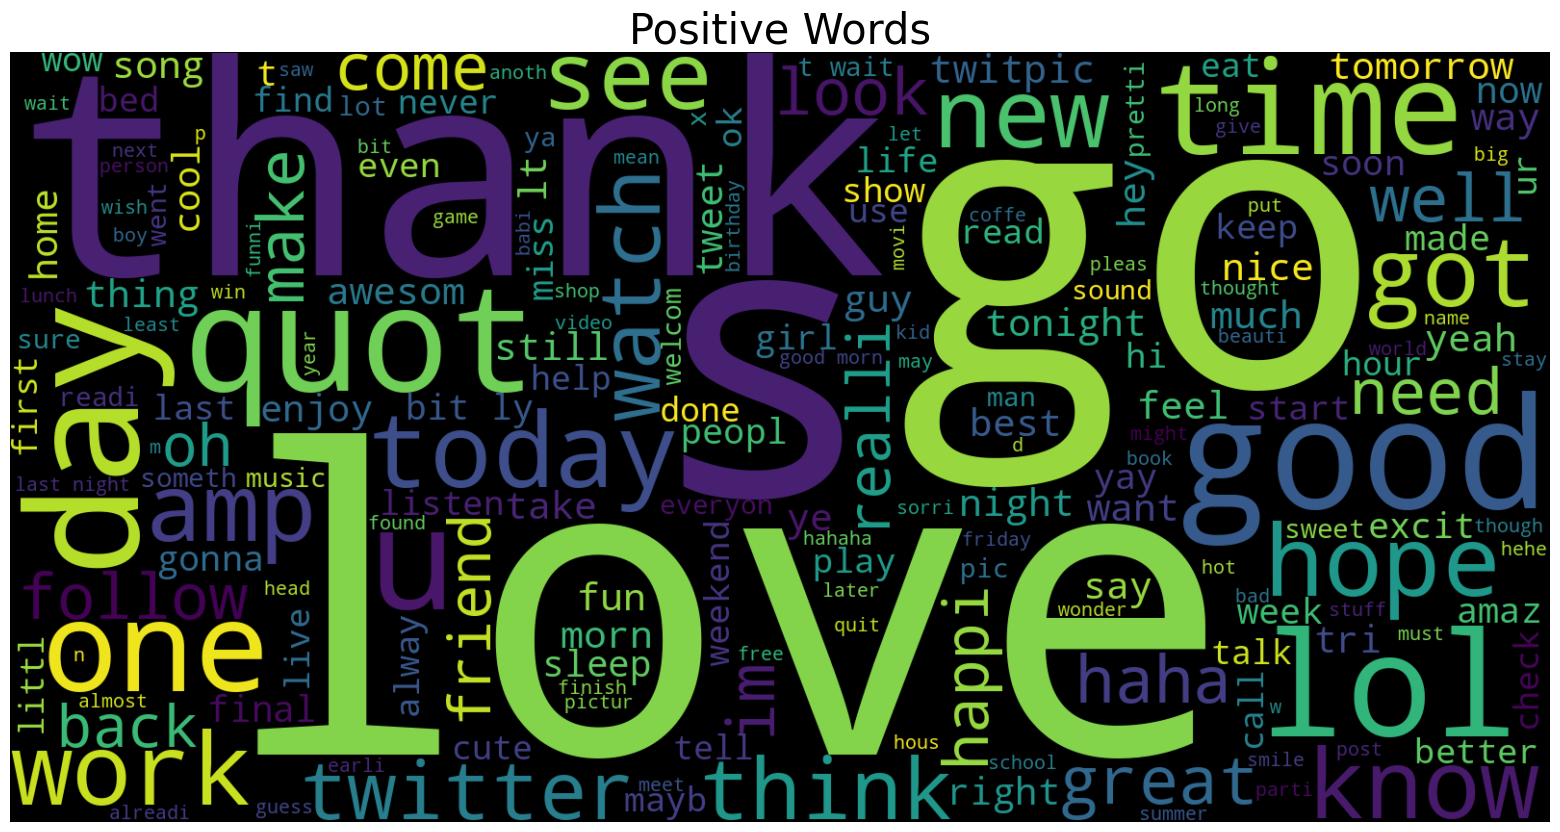

In [ ]:
positive_wordcloud = WordCloud(width = 1600, height = 800, background_color ='black', colormap='viridis', min_font_size = 10).generate(positive)
plt.figure(figsize=(20, 10))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words', fontsize=30)
plt.show()

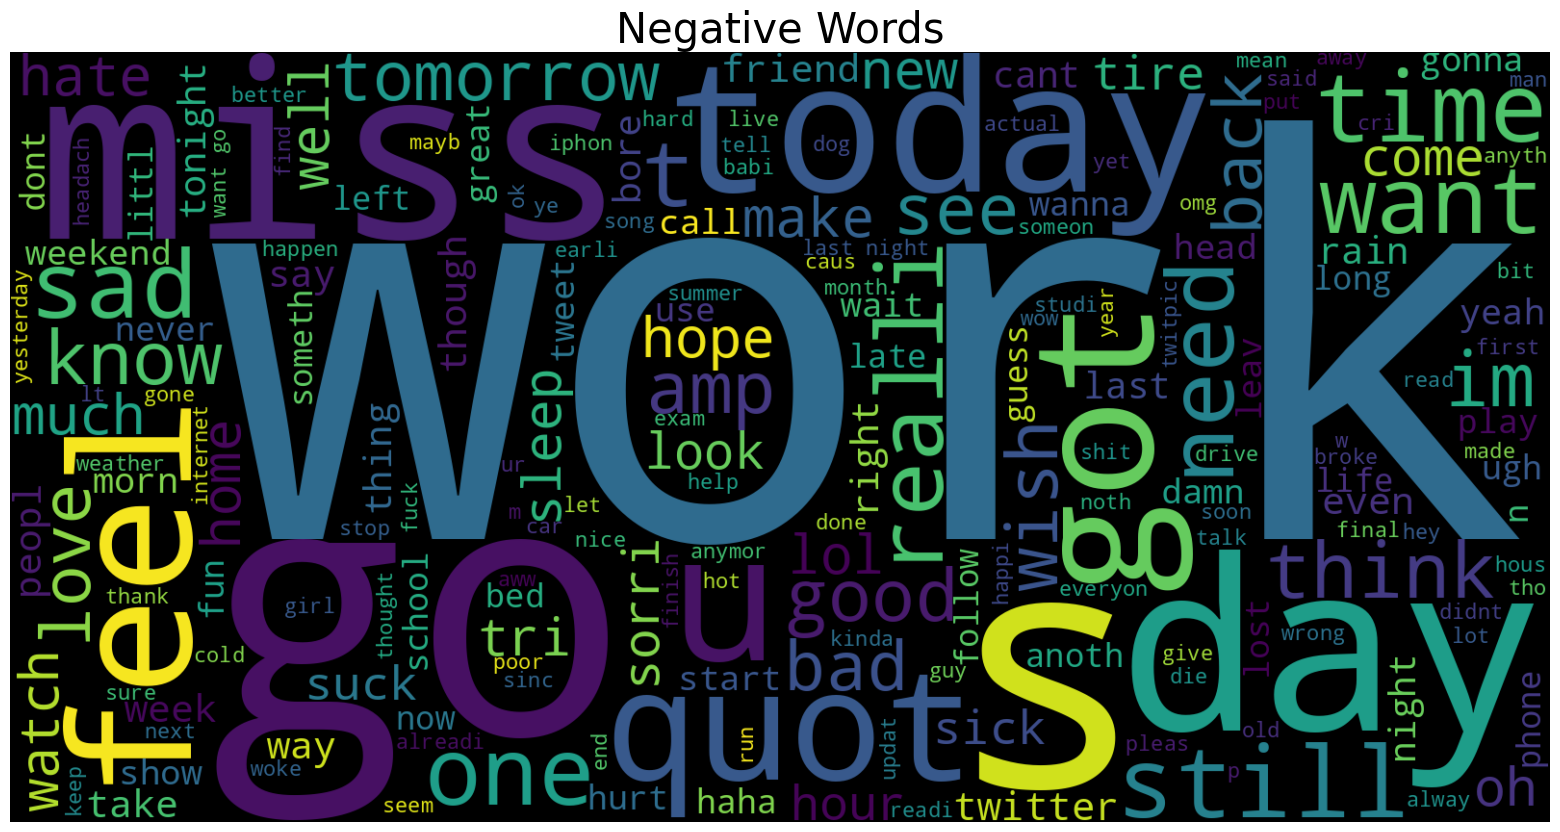

In [ ]:
negative_wordcloud = WordCloud(width = 1600, height = 800, background_color ='black', colormap='viridis', min_font_size = 10).generate(negative)
plt.figure(figsize=(20, 10))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words', fontsize=30)
plt.show()

**I'd like to point out that 'Work' is bigger in the negative words display than it is in the positive words one.**

## TRAINING

**We have now processed the data for training. It's time for us to split it into training and test splits.**

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, stratify=df['sentiment'],random_state=42)

In [ ]:
print(f'Training Set Size: {len(train)}')
print(f'Test Set Size: {len(test)}')

Training Set Size: 9000
Test Set Size: 1000


**It is now time to convert our text sequences into numbers like the model will understand. Fit a tokenizer on the training dataset for the same. Let the vocab size be the no of unique words itself.**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary Size : {vocab_size}')

Vocabulary Size : 10811


**Now transform the training and testing word sequences.**

In [ ]:
train_seq = tokenizer.texts_to_sequences(train['text'])
test_seq = tokenizer.texts_to_sequences(test['text'])

In [ ]:
print('Training data:')
print(train_seq[0])
print('Testing data:')
print(test_seq[0])

Training data:
[5, 832, 1646]
Testing data:
[6, 54, 1208, 31, 2088, 293]


**It is necessary for the simplicity of the model that each text sequence be of the same length. Pad the sequences to make this possible.**

In [ ]:
test_seq = pad_sequences(test_seq, maxlen = 36)
train_seq = pad_sequences(train_seq, maxlen = 36)
print('Training data:')
print(train_seq[0])
print('Testing data:')
print(test_seq[0])

Training data:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  832 1646]
Testing data:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    6   54 1208   31 2088  293]


**Label encode y.**

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['sentiment'] = le.fit_transform(train['sentiment'])
test['sentiment'] = le.transform(test['sentiment'])

In [ ]:
print('The training labels:')
print(train['sentiment'])
print('The testing labels:')
print(test['sentiment'])

The training labels:
9447    1
6813    1
3086    0
5426    1
540     0
       ..
9100    1
5161    1
6974    1
3691    0
131     0
Name: sentiment, Length: 9000, dtype: int64
The testing labels:
6086    1
7941    1
8036    1
7796    1
8262    1
       ..
7799    1
2888    0
6151    1
9013    1
7182    1
Name: sentiment, Length: 1000, dtype: int64


**FOLLOWING CODE IS FOR CREATING WORD EMBEDDINGS. DON'T TOUCH IT.JUST REPLACE VOCAB_SIZE WITH THE VOCABULARY SIZE OBTAINED EARLIER.**

In [ ]:
import tensorflow as tf
import numpy as np
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-06-14 10:16:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-14 10:16:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-14 10:16:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zi

In [ ]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../content/best_model.hdf5'
embeddings_index = {}
f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
embedding_layer = tf.keras.layers.Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],trainable=False)


Found 400000 word vectors.


![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

**You should read up on why we added the previous code block.The embedding layer created is to be used in the model. Use the model summary to build the rest. Compile the model with Adam and a suitable loss function.**

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
MAX_SEQUENCE_LENGTH = 36
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
input_layer = Input(shape=(36,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], trainable=False)(input_layer)
spatial_dropout = SpatialDropout1D(0.2)(embedding_layer)
conv1d_layer = Conv1D(64, kernel_size=5, activation='relu')(spatial_dropout)
bidirectional_layer = Bidirectional(LSTM(64))(conv1d_layer)
dense_1 = Dense(512, activation='relu')(bidirectional_layer)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(512, activation='relu')(dropout_1)
output_layer = Dense(1, activation='sigmoid')(dense_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 36, 300)        │     3,243,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 36, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 64)         │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,734,629 (14.25 MB)

 Trainable params: 491,329 (1.87 MB)

 Non-trainable params: 3,243,300 (12.37 MB)

**Train the model on the train split, and validate it on the test split.**

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    train_seq,
    train['sentiment'],
    batch_size=1000,
    epochs=10,
    validation_data=(test_seq, test['sentiment'])
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5320 - loss: 0.6909 - val_accuracy: 0.6210 - val_loss: 0.6630
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 800ms/step - accuracy: 0.6418 - loss: 0.6439 - val_accuracy: 0.6520 - val_loss: 0.6304
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 831ms/step - accuracy: 0.6753 - loss: 0.6047 - val_accuracy: 0.6730 - val_loss: 0.6154
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7017 - loss: 0.5718 - val_accuracy: 0.6580 - val_loss: 0.6028
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 801ms/step - accuracy: 0.7205 - loss: 0.5404 - val_accuracy: 0.6720 - val_loss: 0.6058
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7450 - loss: 0.5106 - val_accuracy: 0.6910 - val_loss: 0.5965
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 997ms/step - accuracy: 0.7659 - loss: 0.4816 - val_accuracy: 0.6770 - val_loss: 0.6301
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 806ms/step - accuracy: 0.7999 - loss: 0.4332 - val_accuracy: 0.6790 - val_loss: 0.6

**Let's visualise the model's training history now.**

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['Testing '+string, 'Validation '+string])
  plt.title('Training and Validation '+string)
  plt.show()


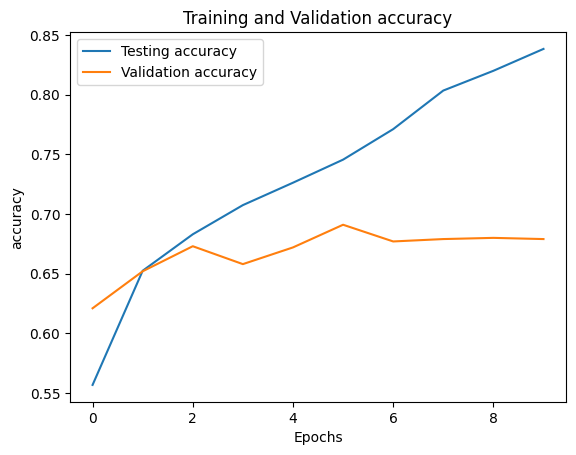

In [ ]:
plot_graphs(history, "accuracy")

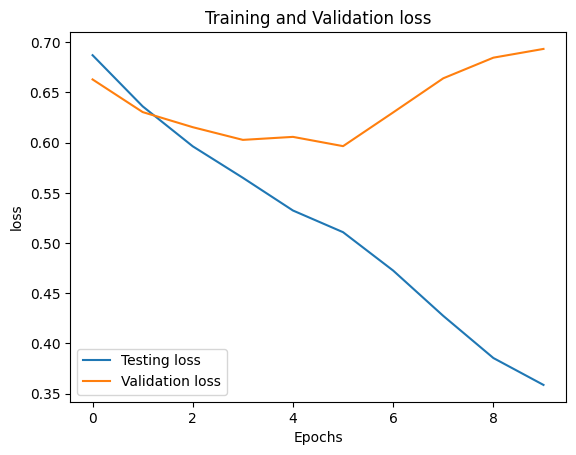

In [ ]:
plot_graphs(history, "loss")

**Lets see what the accuracy of the model is.**

In [ ]:
from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_seq)
y_pred = (y_pred_probs > 0.5).astype(int)
print(classification_report(test['sentiment'], y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

           0       0.67      0.70      0.69       500
           1       0.69      0.65      0.67       500

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



**Take a random input sequence from the text series. First predict on it nd gets its sentiment. Then decode the string using the tokenizer, etc. you've developed and print the string as well.**

In [ ]:
random_index = np.random.randint(0, len(test_seq))
y_hat = model.predict(np.expand_dims(test_seq[random_index], axis=0), verbose = 0)
y_pred = (y_hat > 0.5).astype(int)

def decode(num):
  if num == 0:
    return 'Negative'
  elif num == 1:
    return 'Positive'

print(f'Predicted Label: {decode(y_pred[0][0])}')
print(f'Actual Label: {decode(test["sentiment"].iloc[random_index])}')
print(f'Text: {test["text"].iloc[random_index]}')

Predicted Label: Negative
Actual Label: Negative
Text: ugh


**We can try this on a random string as well.**

In [ ]:
input_str="I hate everyone on earth!"
input = remove_sw(input_str)
print(input)
input = remove_handle_names(input)
input = remove_special_char(input)
print(input)
input = stem_text(input)
print(input)
input = tokenizer.texts_to_sequences([input])
print(input)
input = pad_sequences(input, maxlen = 36)
print(input)

hate everyone earth!
hate everyone earth 
hate everyon earth
[[85, 143, 2706]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   85  143 2706]]


In [ ]:
prediction_prob = model.predict(input, verbose = 0)
prediction = (prediction_prob > 0.5).astype(int)

print(f'Sentiment: {decode(prediction)}')

Sentiment: Negative


## GOOD JOB!